Number of Clusters: 8
Davies-Bouldin Index: 0.7342
Silhouette Score: 0.4943


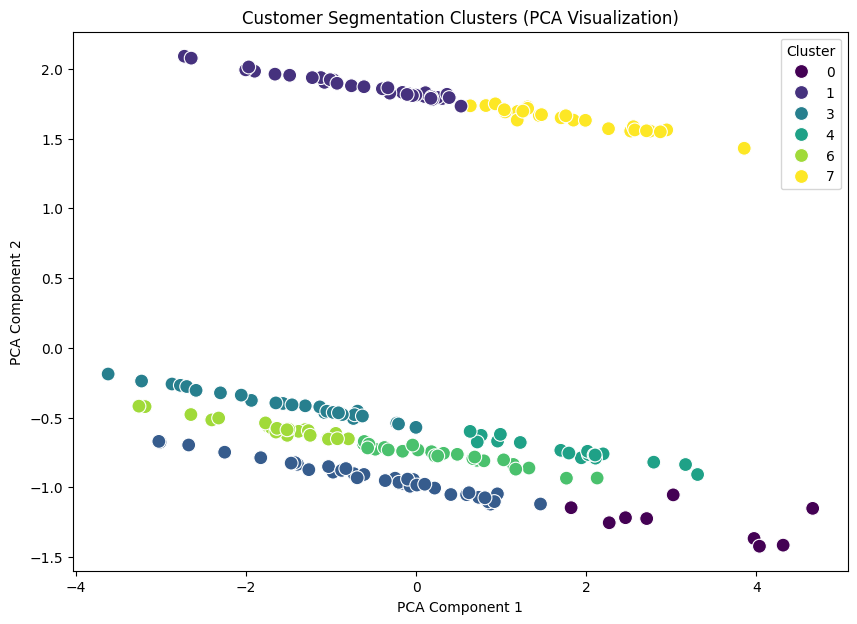

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the customer and transaction datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Merging both those datasets
transactions_agg = transactions.groupby("CustomerID").agg(
    {
        "TotalValue": "sum",  # Total spending
        "Quantity": "sum",  # Total items purchased
        "TransactionID": "count",  # Total number of transactions
    }
).reset_index()

data = customers.merge(transactions_agg, on="CustomerID", how="left")

# Handle missing values
data.fillna(0, inplace=True)

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False)
region_encoded = encoder.fit_transform(data[["Region"]])
region_encoded_df = pd.DataFrame(
    region_encoded, columns=encoder.get_feature_names_out(["Region"])
)

# Combine features
features = pd.concat(
    [
        data[["TotalValue", "Quantity", "TransactionID"]],
        region_encoded_df,
    ],
    axis=1
)

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Clustering
n_clusters = 8 # You can experiment with 2–10 clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

# Add cluster labels to the original data
data["Cluster"] = cluster_labels

# Evaluate Clustering
db_index = davies_bouldin_score(features_scaled, cluster_labels)
silhouette_avg = silhouette_score(features_scaled, cluster_labels)

# Print Metrics
print(f"Number of Clusters: {n_clusters}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Visualize Clusters using PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
data["PCA1"] = features_pca[:, 0]
data["PCA2"] = features_pca[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PCA1", y="PCA2", hue="Cluster", data=data, palette="viridis", s=100
)
plt.title("Customer Segmentation Clusters (PCA Visualization)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

